# Проект для «Викишоп» c BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.  
Требуется модель со значением метрики качества F1 не меньше 0.75.

## Импорт и настройки

In [1]:
!pip install transformers==4.28.0

In [2]:
!pip install datasets

In [3]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import f1_score

pd.set_option('mode.chained_assignment', None)
RANDOM_STATE = 123

## Переменные

Вынесем некоторые перемынные для удобства

In [4]:
TRAIN_TOXIC_RATIO = .15
MODEL_NAME = 'bert-base-uncased'
SAMPLE_TRAIN = 2500
SAMPLE_TEST = 400
LEARNING_RATE = 4.5e-5
NUM_TRAIN_EPOCHS = 2

## Подготовка данных

### Загрузка датасета

In [5]:
link = '/datasets/toxic_comments.csv'
params = {'index_col':0}
df = pd.DataFrame() #spell cheak error

try:
    df = pd.read_csv(link, **params)
except:
    print('Data source unreachable')

### Обзор

In [6]:
df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0


In [7]:
df.isna().mean()

text     0.0
toxic    0.0
dtype: float64

In [8]:
df['text'].duplicated().sum()

0

In [9]:
df['toxic'].mean()

0.10161213369158527

In [10]:
df['text'].apply(len).max()

5000

In [11]:
df['text'].apply(len).idxmax()

4167

Столбец text содержит текст комментария, а toxic — целевой признак. Токсических комментариев 10%.

### Подготовка датасетов

Загружаем токенизатор

In [12]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, do_lower_case=True)

Сделаем функции токенизации, сеплирования и рассчета метрики

In [13]:
def tokenize_function(row):
    return tokenizer(row["text"],
                     add_special_tokens=True,
                     truncation=True,
                     max_length = 512,
                     padding='max_length',
                     return_attention_mask=True,
                     return_tensors='pt')

def get_sample(df, column, size, ratio=.5):
    df_0 = df[df[column] == 0]
    df_1 = df[df[column] == 1]
    size_1 = int(size * ratio)
    sample = pd.concat(
            [
                df_0.sample(size - size_1, random_state=RANDOM_STATE),
                df_1.sample(size_1, random_state=RANDOM_STATE)
            ]
         ).sample(frac=1, random_state=RANDOM_STATE)
    return sample

def compute_f1(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"f1": f1_score(labels, predictions)}

Заменяем имя целевой колонки на label. Разбиваем датасет на тренировочный и тестовый с сохранением баланса классов. Делаем выборки для тренировочного, валидационного и тестового датасетов.

In [14]:
df = df.rename(columns={"toxic": "label"})

df_train, df_valid_test = tts(df, random_state=RANDOM_STATE, test_size=0.1, stratify=df['label'])

train = get_sample(df_train, 'label', SAMPLE_TRAIN, TRAIN_TOXIC_RATIO)
sample = get_sample(df_valid_test, 'label', 2 * SAMPLE_TEST, df_valid_test['label'].mean())
test, valid = tts(sample,
                  random_state=RANDOM_STATE, test_size=0.5, stratify=sample['label'])
print(train['label'].mean(), valid['label'].mean(), test['label'].mean())
print(train.shape, valid.shape, test.shape)

0.15 0.1 0.1025
(2500, 2) (400, 2) (400, 2)


Создаем датасеты.

In [15]:
ds_train = Dataset.from_pandas(train).map(tokenize_function, batched=True)
ds_valid = Dataset.from_pandas(valid).map(tokenize_function, batched=True)
ds_test = Dataset.from_pandas(test).map(tokenize_function, batched=True)

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

## Обучение модели

Загружаем модель

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
    ignore_mismatched_sizes=True
    )
model.to(device);

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Создаем аргументы и создаем экземпляр Trainer

In [17]:
args = TrainingArguments(
    output_dir="output",
    num_train_epochs=NUM_TRAIN_EPOCHS,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy="steps",
    logging_steps=50,
    learning_rate=LEARNING_RATE,
    weight_decay=0.01,
    optim="adamw_torch",
    seed=RANDOM_STATE
)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=ds_train,
    eval_dataset=ds_valid,
    compute_metrics=compute_f1
)

Обучаем

In [18]:
trainer.train()

Step,Training Loss,Validation Loss,F1
50,0.365900,0.146840,0.722222
100,0.214500,0.124297,0.791209
150,0.164800,0.099259,0.835443
200,0.098300,0.115089,0.785714
250,0.095800,0.144657,0.818182
300,0.074700,0.104104,0.829268


TrainOutput(global_step=314, training_loss=0.16742339635350903, metrics={'train_runtime': 561.8162, 'train_samples_per_second': 8.9, 'train_steps_per_second': 0.559, 'total_flos': 1315555276800000.0, 'train_loss': 0.16742339635350903, 'epoch': 2.0})

## Тестирование

Оценим работу модели на тестовой выборке.

F1 на тестовой выборке 0.81



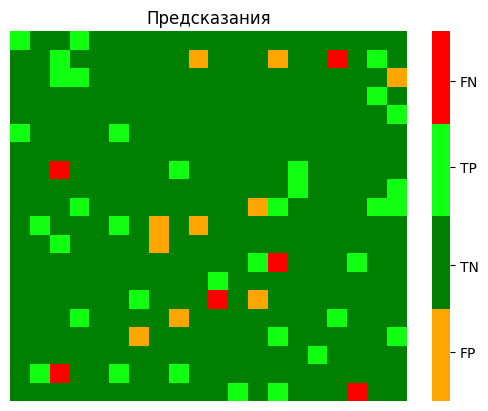

In [19]:
pred = trainer.predict(ds_test)
preds = np.argmax(pred.predictions, axis=-1)
print(f"F1 на тестовой выборке {f1_score(ds_test['label'], preds):.2f}\n")
#print(pred.metrics)
ax = sns.heatmap((ds_test['label'] - .5 * preds).reshape(20, 20), cmap=['orange', 'green','#11ff11', 'red'], yticklabels=False, xticklabels=False)
plt.title('Предсказания')
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.3, 0.05, 0.45, .8])
colorbar.set_ticklabels(['FP', 'TN', 'TP', 'FN'])

Удалось достичь требуемой метрики f1.

## Вывод

Была создана модель для определения токсичности текста на основе предобученной модели bert-base-uncased. Обучение происходило на выборках из-за ограничений производительности. Для тренировочной выборки был сделан небольшой upsample до 15% токсичных комментариев.